In [15]:
import numpy as np
import cv2
import os
import csv
import rasterio
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample
import random
from torch.utils.data import Dataset
import tifffile
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from attention import * 
import time

In [2]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
train_path=root_dir+"txt/train.txt"
val_path=root_dir+"txt/val.txt"
with open(train_path, "r") as t:
    lines_train =t.readlines()
    list_train=[i[:-1] for i in lines_train]
with open(val_path, "r") as v:
    lines_val =v.readlines()
    list_val=[i[:-1] for i in lines_val]   

In [3]:
class SARDataset(Dataset):

    def __init__(self, data_list, preprocess_func):
        self.data_list = data_list
        self.preprocess_func = preprocess_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, i):
        return self.preprocess_func(self.data_list[i])

def processAndAugment(data):
    
    root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
    
    S1 = root_dir+"S1/"+data+"_S1Hand.tif"
    DEM = root_dir+"DEM/"+data+"_DEM.tif"
    Label=root_dir+"Label/"+data+"_LabelHand.tif"
    
    S1_data=np.nan_to_num(tifffile.imread(S1))
    DEM_data=tifffile.imread(DEM)
    Label_data=np.uint8(rasterio.open(Label).read())
   # Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()    
    
    arr_x = np.clip(S1_data, -50, 1)
    arr_x = (arr_x + 50) / 51
    S1_0_NORM = arr_x[0]
    S1_1_NORM = arr_x[1]

    #S1_data=np.nan_to_num(rasterio.open(S1).read())
   # DEM_data=rasterio.open(DEM).read()
    #Label_data=np.uint8(rasterio.open(Label).read())
    #Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()
    
    DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
#    S1_0_NORM = (S1_data[0] - np.min(S1_data[0])) / (np.max(S1_data[0]) - np.min(S1_data[0]))
#    S1_1_NORM = (S1_data[1] - np.min(S1_data[1])) / (np.max(S1_data[1]) - np.min(S1_data[1]))

   # for l in location:
   #     DEM_NORM[l[0],l[1],l[2]]=0
   #     S1_0_NORM[l[1],l[2]]=0
   #     S1_1_NORM[l[1],l[2]]=0
    
    S1_0_NORM = np.expand_dims(S1_0_NORM, axis=0)
    S1_1_NORM = np.expand_dims(S1_1_NORM, axis=0)
    S0_NORM = torch.from_numpy(S1_0_NORM)#.float
    S1_NORM = torch.from_numpy(S1_1_NORM)#.float
    DEM = torch.from_numpy(DEM_NORM)#.float
    Label = torch.from_numpy(Label_data).squeeze().long()
    
    SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
    #x= torch.tensor(SUM, dtype=torch.float32)
    #X_data = np.stack((S1_0_NORM, S1_1_NORM, DEM_NORM), axis=0)  
    
   # x_transforms = transforms.Compose([
  #  transforms.ToTensor(),
  #  transforms.Normalize([0.5], [0.5])])

# mask只需要转换为tensor
  #  y_transforms = transforms.ToTensor()
    
    return SUM,Label

In [4]:
train_dataset = SARDataset(list_train, processAndAugment)
val_dataset = SARDataset(list_val, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
len(train_dataloader.dataset)

312

In [12]:
def train_model(model, criterion, optimizer, dataload, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [13]:
def train():
    model = UNet().to(device)
    batch_size = 2
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    train_dataset = SARDataset(list_train, processAndAugment)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    train_model(model, criterion, optimizer, train_dataloader)

In [14]:
train()

In [34]:
def train_model(model, criterion, optimizer, dataload, num_epochs=200):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [7]:
model = UNet()
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_dataset = SARDataset(list_train, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_dataset = SARDataset(list_val, processAndAugment)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [8]:
training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy

    # zero the parameter gradients
    optimizer.zero_grad()
    net = net.to(device)

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    ###scheduler.step()

    running_loss += loss.item()
    running_iou += computeIOU(outputs, labels)
    running_accuracy += computeAccuracy(outputs, labels)
    running_count += 1
    

In [9]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global max_valid_iou

    global training_losses
    global training_accuracies
    global training_ious
    global valid_losses
    global valid_accuracies
    global valid_ious

    net = net.eval()
    net = net.to(device)
    count = 0
    iou = 0
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for (images, labels) in validation_data_loader:
            net = net.to(device)
            outputs = net(images.to(device))
            valid_loss = criterion(outputs, labels.to(device))
            valid_iou = computeIOU(outputs, labels.to(device))
            valid_accuracy = computeAccuracy(outputs, labels.to(device))
            iou += valid_iou
            loss += valid_loss
            accuracy += valid_accuracy
            count += 1

    iou = iou / count
    accuracy = accuracy / count

    if iou > max_valid_iou:
        max_valid_iou = iou
        aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
        file= "{}_{}_{}.cp".format(RUNNAME, i, iou.item())     
        save_path = aaa+file
        torch.save(net.state_dict(), save_path)
        print("model saved at", save_path)

    loss = loss / count
    print("Training Loss:", running_loss / running_count)
    print("Training IOU:", running_iou / running_count)
    print("Training Accuracy:", running_accuracy / running_count)
    print("Validation Loss:", loss)
    print("Validation IOU:", iou)
    print("Validation Accuracy:", accuracy)


    training_losses.append(running_loss / running_count)
    training_accuracies.append(running_accuracy / running_count)
    training_ious.append(running_iou / running_count)
    valid_losses.append(loss)
    valid_accuracies.append(accuracy)
    valid_ious.append(iou)

In [10]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer,  train_loader):
    for inputs, labels in train_loader:
        train_loop(inputs.to(device), labels.to(device), net.to(device), optimizer)

        
        
def  train_validation_loop(net, optimizer,train_loader,
                          valid_loader, num_epochs, cur_epoch):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    net = net.train()
    running_loss = 0
    running_iou = 0
    running_count = 0
    running_accuracy = 0

    for i in range(num_epochs):
        train_epoch(net, optimizer, train_loader)
    clear_output()

    print("Current Epoch:", cur_epoch)
    validation_loop(valid_loader, net)


In [11]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 5):
    train_validation_loop(model, optimizer, train_dataloader, val_dataloader, 5, i)
    epochs.append(i)
    x = epochs
    plt.plot(x, training_losses, label='training losses')
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')
    plt.plot(x, valid_losses, label='valid losses')
    plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
    plt.plot(x, valid_ious, 'tab:green',label='valid iou')
    plt.legend(loc="upper left")

    display(plt.show())

    print("max valid iou:", max_valid_iou)

<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)
<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)
<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)


In [ ]:
running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

In [ ]:
def train_model(model, criterion, optimizer, dataload, val, num_epochs=200):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [ ]:
running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

In [9]:
def computeIOU(output, target):
    
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    intersection = torch.sum(output * target)
    union = torch.sum(target) + torch.sum(output) - intersection
    iou = (intersection + .0000001) / (union + .0000001)

    return iou

def computeAccuracy(output, target):
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    correct = torch.sum(output.eq(target))

    return correct.float() / len(target)

In [10]:
model = UNet().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_dataset = SARDataset(list_train, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_dataset = SARDataset(list_val, processAndAugment)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [16]:
def train_model(model, criterion, optimizer, dataload, val, num_epochs=2):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global max_valid_iou
    
    global training_losses
    global training_accuracies
    global training_ious
    global valid_losses
    global valid_accuracies
    global valid_ious
    global epochs 
    max_valid_iou = 0
    
    training_losses = []
    training_accuracies = []
    training_ious = []
    valid_losses = []
    valid_accuracies = []
    valid_ious = []
    epochs = []
   
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        start = time.time()
        dt_size = len(dataload.dataset)
        val_size = len(val.dataset)
        running_loss = 0
        running_iou = 0
        running_count = 0
        running_accuracy = 0
        #epoch_loss = 0
        #step = 0
        for x, y in dataload:
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_iou += computeIOU(outputs, labels)
            running_accuracy += computeAccuracy(outputs, labels)
            running_count += 1
            #print("%d/%d,train_loss:%0.3f" % (running_count, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        #print("epoch %d loss:%0.3f" % (epoch, running_loss/running_count))
        
        model = model.eval()
        count = 0
        iou = 0
        loss = 0
        accuracy = 0
        with torch.no_grad():
            for x, y in val:
                x= torch.tensor(x, dtype=torch.float32)
                model = model.to(device)
                inputs = x.to(device)
                labels = y.to(device)
                outputs = model(inputs)
                valid_loss = criterion(outputs, labels)
                valid_iou = computeIOU(outputs, labels)
                valid_accuracy = computeAccuracy(outputs, labels)
                iou += valid_iou
                loss += valid_loss
                accuracy += valid_accuracy
                count += 1

        iou = iou / count
        accuracy = accuracy / count

        if iou > max_valid_iou:
            max_valid_iou = iou
            aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/"
            file= "{}_{}.pth".format(epoch, iou.item())     
            save_path = aaa+file
            torch.save(model.state_dict(), save_path)
            print("model saved at", save_path)

        loss = loss / count
        end = time.time()
        print("epoch:" ,epoch)
        print("time:" ,end-start)
        print("Training Loss:", running_loss / running_count)
        print("Training IOU:", (running_iou / running_count).item())
        print("Training Accuracy:", (running_accuracy / running_count).item())
        print("Validation Loss:", loss.item())
        print("Validation IOU:", iou.item())
        print("Validation Accuracy:", accuracy.item())


        training_losses.append((running_loss / running_count))
        training_accuracies.append((running_accuracy / running_count).item())
        training_ious.append((running_iou / running_count).item())
        valid_losses.append(loss.item())
        valid_accuracies.append(accuracy.item())
        valid_ious.append(iou.item())    
        epochs.append(epoch)
        
        
        
        
        
#    aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
#    torch.save(model.state_dict(), aaa+'weights_%d.pth' % epoch)
#    return model

In [17]:
import warnings
warnings.filterwarnings("ignore")
train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=500)

Epoch 0/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/0_0.26369282603263855.pth
epoch: 0
time: 78.27759408950806
Training Loss: 0.17114142256860548
Training IOU: 0.3404000699520111
Training Accuracy: 0.9426380395889282
Validation Loss: 0.17834340035915375
Validation IOU: 0.26369282603263855
Validation Accuracy: 0.9363804459571838
Epoch 1/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/1_0.2818484902381897.pth
epoch: 1
time: 81.23459124565125
Training Loss: 0.16405510088691536
Training IOU: 0.35456013679504395
Training Accuracy: 0.9417977333068848
Validation Loss: 0.1832582950592041
Validation IOU: 0.2818484902381897
Validation Accuracy: 0.9332609176635742
Epoch 2/499
----------
epoch: 2
time: 80.59176349639893
Training Loss: 0.15343510528477147
Training IOU: 0.3695882260799408
Training Accuracy: 0.9471065998077393
Validation Loss: 0.1721365749835968
Validation IOU: 0.2637943625450134
Validation Accu

epoch: 29
time: 81.16840052604675
Training Loss: 0.11939591274429591
Training IOU: 0.42979779839515686
Training Accuracy: 0.9558014869689941
Validation Loss: 0.133223295211792
Validation IOU: 0.27626127004623413
Validation Accuracy: 0.9483188390731812
Epoch 30/499
----------
epoch: 30
time: 81.09793138504028
Training Loss: 0.10971965430937229
Training IOU: 0.4333619475364685
Training Accuracy: 0.9597036242485046
Validation Loss: 0.1245410367846489
Validation IOU: 0.28305232524871826
Validation Accuracy: 0.9517320990562439
Epoch 31/499
----------
epoch: 31
time: 81.11628603935242
Training Loss: 0.10768621990110916
Training IOU: 0.4428394138813019
Training Accuracy: 0.9607405066490173
Validation Loss: 0.1520339846611023
Validation IOU: 0.2103656828403473
Validation Accuracy: 0.9434157609939575
Epoch 32/499
----------
epoch: 32
time: 81.12478470802307
Training Loss: 0.1076086422156853
Training IOU: 0.44147947430610657
Training Accuracy: 0.9588953852653503
Validation Loss: 0.12240416556596

epoch: 58
time: 80.95455837249756
Training Loss: 0.09087163183273962
Training IOU: 0.4957781732082367
Training Accuracy: 0.966680109500885
Validation Loss: 0.11233214288949966
Validation IOU: 0.34119200706481934
Validation Accuracy: 0.9560624361038208
Epoch 59/499
----------
epoch: 59
time: 80.89560413360596
Training Loss: 0.08906511932563706
Training IOU: 0.49411842226982117
Training Accuracy: 0.9671487212181091
Validation Loss: 0.11331664770841599
Validation IOU: 0.37870749831199646
Validation Accuracy: 0.9561851024627686
Epoch 60/499
----------
epoch: 60
time: 80.96627879142761
Training Loss: 0.08558068112007533
Training IOU: 0.4927622675895691
Training Accuracy: 0.9685221314430237
Validation Loss: 0.11748339980840683
Validation IOU: 0.3796501159667969
Validation Accuracy: 0.9561153054237366
Epoch 61/499
----------
epoch: 61
time: 80.97571730613708
Training Loss: 0.10523396875195874
Training IOU: 0.4708142876625061
Training Accuracy: 0.9625510573387146
Validation Loss: 0.11455123126

epoch: 87
time: 80.87608098983765
Training Loss: 0.07511774650685346
Training IOU: 0.5385230779647827
Training Accuracy: 0.9720152020454407
Validation Loss: 0.10511431843042374
Validation IOU: 0.39677488803863525
Validation Accuracy: 0.9629676342010498
Epoch 88/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/88_0.4289165139198303.pth
epoch: 88
time: 81.72475695610046
Training Loss: 0.0812739786648681
Training IOU: 0.5011736750602722
Training Accuracy: 0.9698137044906616
Validation Loss: 0.10341523587703705
Validation IOU: 0.4289165139198303
Validation Accuracy: 0.9617500901222229
Epoch 89/499
----------
epoch: 89
time: 80.79256534576416
Training Loss: 0.07729290642489034
Training IOU: 0.5368674993515015
Training Accuracy: 0.9713355898857117
Validation Loss: 0.11838949471712112
Validation IOU: 0.3697029650211334
Validation Accuracy: 0.958051860332489
Epoch 90/499
----------
epoch: 90
time: 80.86746191978455
Training Loss: 0.07499629200566023
Tr

epoch: 116
time: 80.91600131988525
Training Loss: 0.06546051323769064
Training IOU: 0.5729189515113831
Training Accuracy: 0.974966824054718
Validation Loss: 0.09775958955287933
Validation IOU: 0.44057580828666687
Validation Accuracy: 0.9651540517807007
Epoch 117/499
----------
epoch: 117
time: 80.9016375541687
Training Loss: 0.06201395370478097
Training IOU: 0.589454710483551
Training Accuracy: 0.9764912128448486
Validation Loss: 0.09868589043617249
Validation IOU: 0.4285370409488678
Validation Accuracy: 0.9654480814933777
Epoch 118/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/118_0.44888943433761597.pth
epoch: 118
time: 81.71104335784912
Training Loss: 0.06690850415870021
Training IOU: 0.5624741911888123
Training Accuracy: 0.9743431210517883
Validation Loss: 0.09494142979383469
Validation IOU: 0.44888943433761597
Validation Accuracy: 0.9652330875396729
Epoch 119/499
----------
epoch: 119
time: 80.88348150253296
Training Loss: 0.06400064613

epoch: 143
time: 80.96963262557983
Training Loss: 0.05235181690155654
Training IOU: 0.635237991809845
Training Accuracy: 0.9793699383735657
Validation Loss: 0.09083924442529678
Validation IOU: 0.4925551414489746
Validation Accuracy: 0.9646469354629517
Epoch 144/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/144_0.506646454334259.pth
epoch: 144
time: 81.79510021209717
Training Loss: 0.05099436207157664
Training IOU: 0.662577748298645
Training Accuracy: 0.9797765612602234
Validation Loss: 0.09288813918828964
Validation IOU: 0.506646454334259
Validation Accuracy: 0.9650653600692749
Epoch 145/499
----------
epoch: 145
time: 80.89837741851807
Training Loss: 0.05088183902075681
Training IOU: 0.6408166289329529
Training Accuracy: 0.9798422455787659
Validation Loss: 0.08712168037891388
Validation IOU: 0.5026938915252686
Validation Accuracy: 0.9678645730018616
Epoch 146/499
----------
epoch: 146
time: 81.00987219810486
Training Loss: 0.048840175646499

epoch: 172
time: 80.99525690078735
Training Loss: 0.044761652302930506
Training IOU: 0.6819421648979187
Training Accuracy: 0.981848418712616
Validation Loss: 0.08838100731372833
Validation IOU: 0.5286557078361511
Validation Accuracy: 0.9683149456977844
Epoch 173/499
----------
epoch: 173
time: 80.98151922225952
Training Loss: 0.04362754636456838
Training IOU: 0.6703341603279114
Training Accuracy: 0.9822944402694702
Validation Loss: 0.08924213796854019
Validation IOU: 0.5407638549804688
Validation Accuracy: 0.9705753922462463
Epoch 174/499
----------
epoch: 174
time: 81.00328850746155
Training Loss: 0.046782790138259325
Training IOU: 0.6657189726829529
Training Accuracy: 0.9814033508300781
Validation Loss: 0.09560956060886383
Validation IOU: 0.5411245822906494
Validation Accuracy: 0.9653764367103577
Epoch 175/499
----------
epoch: 175
time: 81.00240182876587
Training Loss: 0.04425322923625339
Training IOU: 0.6610740423202515
Training Accuracy: 0.9821590781211853
Validation Loss: 0.07934

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/200_0.5940408110618591.pth
epoch: 200
time: 81.68461585044861
Training Loss: 0.03580026991039631
Training IOU: 0.7214744091033936
Training Accuracy: 0.9852617979049683
Validation Loss: 0.08351428061723709
Validation IOU: 0.5940408110618591
Validation Accuracy: 0.973025918006897
Epoch 201/499
----------
epoch: 201
time: 80.83529901504517
Training Loss: 0.03529183511499795
Training IOU: 0.747023344039917
Training Accuracy: 0.9854702949523926
Validation Loss: 0.08370901644229889
Validation IOU: 0.5876308679580688
Validation Accuracy: 0.9730343818664551
Epoch 202/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/202_0.604883074760437.pth
epoch: 202
time: 81.76910209655762
Training Loss: 0.03605933204138031
Training IOU: 0.7399054169654846
Training Accuracy: 0.9850990176200867
Validation Loss: 0.08069293946027756
Validation IOU: 0.604883074760437
Validation Accuracy: 0.972766

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/227_0.6297563910484314.pth
epoch: 227
time: 81.72832441329956
Training Loss: 0.032256543380800654
Training IOU: 0.7563143372535706
Training Accuracy: 0.9866206049919128
Validation Loss: 0.08290982246398926
Validation IOU: 0.6297563910484314
Validation Accuracy: 0.9737623333930969
Epoch 228/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/228_0.6323866844177246.pth
epoch: 228
time: 81.70131397247314
Training Loss: 0.031764678936899424
Training IOU: 0.7634784579277039
Training Accuracy: 0.9868018627166748
Validation Loss: 0.08136036992073059
Validation IOU: 0.6323866844177246
Validation Accuracy: 0.9751992225646973
Epoch 229/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/229_0.6330578327178955.pth
epoch: 229
time: 81.69580411911011
Training Loss: 0.03158645932959795
Training IOU: 0.7700086832046509
Training Accuracy: 0.986864030

epoch: 255
time: 80.89297890663147
Training Loss: 0.029573556893154045
Training IOU: 0.7644309401512146
Training Accuracy: 0.9876852035522461
Validation Loss: 0.08082543313503265
Validation IOU: 0.6454542279243469
Validation Accuracy: 0.975580096244812
Epoch 256/499
----------
epoch: 256
time: 80.94793105125427
Training Loss: 0.03200399542551261
Training IOU: 0.7714080810546875
Training Accuracy: 0.9866575598716736
Validation Loss: 0.09072073549032211
Validation IOU: 0.6241143345832825
Validation Accuracy: 0.9724037051200867
Epoch 257/499
----------
epoch: 257
time: 81.06790828704834
Training Loss: 0.03126509446365862
Training IOU: 0.7552828192710876
Training Accuracy: 0.9869608879089355
Validation Loss: 0.07769537717103958
Validation IOU: 0.6464446783065796
Validation Accuracy: 0.9756793975830078
Epoch 258/499
----------
epoch: 258
time: 80.95871162414551
Training Loss: 0.03018604237983406
Training IOU: 0.7752860188484192
Training Accuracy: 0.9873580932617188
Validation Loss: 0.075208

epoch: 283
time: 81.04073190689087
Training Loss: 0.025796058823102496
Training IOU: 0.8069547414779663
Training Accuracy: 0.9892264008522034
Validation Loss: 0.08004730194807053
Validation IOU: 0.6673994064331055
Validation Accuracy: 0.9753992557525635
Epoch 284/499
----------
epoch: 284
time: 80.98363590240479
Training Loss: 0.027100222966906493
Training IOU: 0.8047269582748413
Training Accuracy: 0.9886787533760071
Validation Loss: 0.07544472068548203
Validation IOU: 0.6523091793060303
Validation Accuracy: 0.9759116768836975
Epoch 285/499
----------
epoch: 285
time: 80.98180437088013
Training Loss: 0.02813354730151565
Training IOU: 0.8092919588088989
Training Accuracy: 0.9882240295410156
Validation Loss: 0.07750198990106583
Validation IOU: 0.668645977973938
Validation Accuracy: 0.9761644005775452
Epoch 286/499
----------
epoch: 286
time: 80.95337677001953
Training Loss: 0.026193073206146576
Training IOU: 0.8108315467834473
Training Accuracy: 0.9890183806419373
Validation Loss: 0.0786

epoch: 311
time: 81.00627183914185
Training Loss: 0.02288468231434903
Training IOU: 0.8276876211166382
Training Accuracy: 0.9904426336288452
Validation Loss: 0.08206497132778168
Validation IOU: 0.685882568359375
Validation Accuracy: 0.9771491289138794
Epoch 312/499
----------
epoch: 312
time: 81.15240240097046
Training Loss: 0.023498249858186264
Training IOU: 0.8329925537109375
Training Accuracy: 0.9901646375656128
Validation Loss: 0.08521062135696411
Validation IOU: 0.6832215785980225
Validation Accuracy: 0.977451741695404
Epoch 313/499
----------
epoch: 313
time: 81.20563578605652
Training Loss: 0.02435713831581756
Training IOU: 0.8267715573310852
Training Accuracy: 0.9897862076759338
Validation Loss: 0.08139250427484512
Validation IOU: 0.685889720916748
Validation Accuracy: 0.9777354598045349
Epoch 314/499
----------
epoch: 314
time: 81.26991438865662
Training Loss: 0.025356784358010396
Training IOU: 0.8168050050735474
Training Accuracy: 0.9893905520439148
Validation Loss: 0.0848108

epoch: 340
time: 81.26835322380066
Training Loss: 0.024786214111745954
Training IOU: 0.8070310354232788
Training Accuracy: 0.9895870685577393
Validation Loss: 0.08437064290046692
Validation IOU: 0.6802622675895691
Validation Accuracy: 0.9769445657730103
Epoch 341/499
----------
epoch: 341
time: 81.3083016872406
Training Loss: 0.028745134114265405
Training IOU: 0.7887855172157288
Training Accuracy: 0.9880520105361938
Validation Loss: 0.08896586298942566
Validation IOU: 0.6754025220870972
Validation Accuracy: 0.9759204983711243
Epoch 342/499
----------
epoch: 342
time: 81.39693927764893
Training Loss: 0.02588213859229281
Training IOU: 0.821137547492981
Training Accuracy: 0.9891498684883118
Validation Loss: 0.08530262857675552
Validation IOU: 0.6867173910140991
Validation Accuracy: 0.977364718914032
Epoch 343/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/se/343_0.6948487758636475.pth
epoch: 343
time: 82.09280824661255
Training Loss: 0.022765325709

epoch: 368
time: 81.4616596698761
Training Loss: 0.021204857468016296
Training IOU: 0.8420169353485107
Training Accuracy: 0.9910885691642761
Validation Loss: 0.10106957703828812
Validation IOU: 0.6765621900558472
Validation Accuracy: 0.9759945273399353
Epoch 369/499
----------
epoch: 369
time: 81.46089005470276
Training Loss: 0.022538236057447973
Training IOU: 0.8272573351860046
Training Accuracy: 0.990524411201477
Validation Loss: 0.09621128439903259
Validation IOU: 0.6721681952476501
Validation Accuracy: 0.9760957360267639
Epoch 370/499
----------
epoch: 370
time: 81.42756533622742
Training Loss: 0.02195287432393856
Training IOU: 0.8485523462295532
Training Accuracy: 0.9907691478729248
Validation Loss: 0.07996594905853271
Validation IOU: 0.6880021691322327
Validation Accuracy: 0.9774418473243713
Epoch 371/499
----------
epoch: 371
time: 81.43613886833191
Training Loss: 0.02258195249951547
Training IOU: 0.8380018472671509
Training Accuracy: 0.9904935956001282
Validation Loss: 0.081316

epoch: 397
time: 81.61869645118713
Training Loss: 0.020837856754310335
Training IOU: 0.8567090034484863
Training Accuracy: 0.991214394569397
Validation Loss: 0.0827627032995224
Validation IOU: 0.7081518173217773
Validation Accuracy: 0.9781777858734131
Epoch 398/499
----------
epoch: 398
time: 81.58072924613953
Training Loss: 0.021137771871674607
Training IOU: 0.8576774001121521
Training Accuracy: 0.9911260604858398
Validation Loss: 0.07952266931533813
Validation IOU: 0.7101143598556519
Validation Accuracy: 0.978609561920166
Epoch 399/499
----------
epoch: 399
time: 81.64587593078613
Training Loss: 0.01963677748130685
Training IOU: 0.8644291758537292
Training Accuracy: 0.9917325973510742
Validation Loss: 0.08463805913925171
Validation IOU: 0.7118235230445862
Validation Accuracy: 0.9783558249473572
Epoch 400/499
----------
epoch: 400
time: 81.69461488723755
Training Loss: 0.020204234768616748
Training IOU: 0.8486594557762146
Training Accuracy: 0.9915108680725098
Validation Loss: 0.096010

epoch: 425
time: 81.64476323127747
Training Loss: 0.01928837348889782
Training IOU: 0.8590967059135437
Training Accuracy: 0.9919039607048035
Validation Loss: 0.08831425756216049
Validation IOU: 0.7126197218894958
Validation Accuracy: 0.9784705638885498
Epoch 426/499
----------
epoch: 426
time: 81.76460599899292
Training Loss: 0.019457363201418516
Training IOU: 0.8473705649375916
Training Accuracy: 0.9918205142021179
Validation Loss: 0.08843543380498886
Validation IOU: 0.7097284197807312
Validation Accuracy: 0.978827178478241
Epoch 427/499
----------
epoch: 427
time: 81.74535393714905
Training Loss: 0.02029596758310011
Training IOU: 0.8595468401908875
Training Accuracy: 0.9914713501930237
Validation Loss: 0.0882238894701004
Validation IOU: 0.7028207182884216
Validation Accuracy: 0.9789336323738098
Epoch 428/499
----------
epoch: 428
time: 81.66814136505127
Training Loss: 0.020533064139572278
Training IOU: 0.8449779748916626
Training Accuracy: 0.991357684135437
Validation Loss: 0.0865300

epoch: 455
time: 81.77168679237366
Training Loss: 0.017639845813336344
Training IOU: 0.8683242797851562
Training Accuracy: 0.9926034808158875
Validation Loss: 0.09180852025747299
Validation IOU: 0.7234089374542236
Validation Accuracy: 0.9787814617156982
Epoch 456/499
----------
epoch: 456
time: 81.75893545150757
Training Loss: 0.01723567812776321
Training IOU: 0.8805903792381287
Training Accuracy: 0.9927806258201599
Validation Loss: 0.08774171024560928
Validation IOU: 0.7224803566932678
Validation Accuracy: 0.979334831237793
Epoch 457/499
----------
epoch: 457
time: 81.78205132484436
Training Loss: 0.018257352333599115
Training IOU: 0.8598872423171997
Training Accuracy: 0.9923295378684998
Validation Loss: 0.08548293262720108
Validation IOU: 0.7200278043746948
Validation Accuracy: 0.9793639779090881
Epoch 458/499
----------
epoch: 458
time: 81.8370954990387
Training Loss: 0.017900780717051628
Training IOU: 0.8622604608535767
Training Accuracy: 0.9924943447113037
Validation Loss: 0.08932

epoch: 485
time: 81.72273302078247
Training Loss: 0.017417865700823452
Training IOU: 0.8662205338478088
Training Accuracy: 0.9926902651786804
Validation Loss: 0.08301684260368347
Validation IOU: 0.710163414478302
Validation Accuracy: 0.9788687229156494
Epoch 486/499
----------
epoch: 486
time: 82.10777115821838
Training Loss: 0.018161041214689717
Training IOU: 0.8708762526512146
Training Accuracy: 0.9923757910728455
Validation Loss: 0.08294982463121414
Validation IOU: 0.7256699800491333
Validation Accuracy: 0.9792913198471069
Epoch 487/499
----------
epoch: 487
time: 81.75817584991455
Training Loss: 0.01811474556973572
Training IOU: 0.8573613166809082
Training Accuracy: 0.9923865795135498
Validation Loss: 0.09401100873947144
Validation IOU: 0.7120078802108765
Validation Accuracy: 0.9786619544029236
Epoch 488/499
----------
epoch: 488
time: 81.72663450241089
Training Loss: 0.018228393167215147
Training IOU: 0.8592360019683838
Training Accuracy: 0.9923254251480103
Validation Loss: 0.0823

In [55]:
mod="Final/se/493_0.7346614003181458.pth"
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_train[1]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

In [20]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]
S1_1_NORM = arr_x[1]

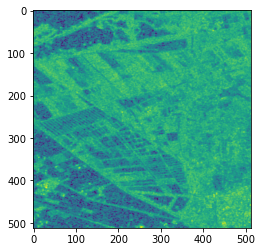

In [23]:
plt.imshow(S1_1_NORM)

In [24]:
DEM_data=tifffile.imread(dem)

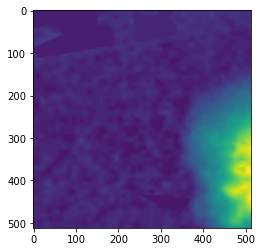

In [25]:
plt.imshow(DEM_data[0])

In [26]:
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0

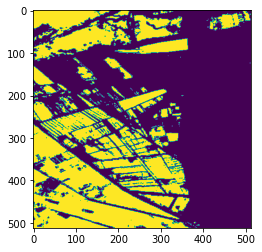

In [27]:
plt.imshow(Label_data[0])

In [28]:
NET=UNet()
checkpoint = torch.load(path+mod)
NET.load_state_dict(checkpoint)

<All keys matched successfully>

In [29]:
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
inputs=SUM.unsqueeze(0)

In [30]:
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()

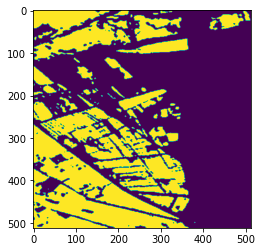

In [31]:
plt.imshow(a[0])


In [18]:
max_valid_iou

tensor(0.7347, device='cuda:0')

In [ ]:
rain_validation_loop(model, optimizer, train_dataloader, val_dataloader, 5, i)
    epochs.append(i)
    x = epochs
    plt.plot(x, training_losses, label='training losses')
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')
    plt.plot(x, valid_losses, label='valid losses')
    plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
    plt.plot(x, valid_ious, 'tab:green',label='valid iou')
    plt.legend(loc="upper left")

    display(plt.show())

    print("max valid iou:", max_valid_iou)

In [15]:
x=[]
for i in range(0,500):
    x.append(i)

In [32]:
import pandas as pd

In [33]:
result =pd.DataFrame(columns=('epochs','t_loss','t_acc','t_iou','v_loss','v_acc','v_iou'))

In [34]:
result["epochs"]=epochs

In [35]:
result["t_loss"]=training_losses
result["t_acc"]=training_accuracies
result["t_iou"]=training_ious
result["v_loss"]=valid_losses
result["v_acc"]=valid_accuracies
result["v_iou"]=valid_ious

In [36]:
result.to_csv("new_i1i2dem_500se.csv")

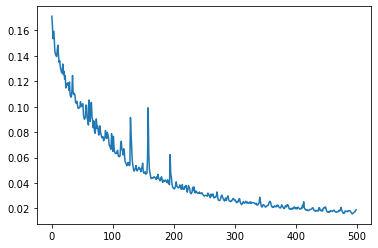

In [38]:
plt.plot(epochs, training_losses, label='training losses')

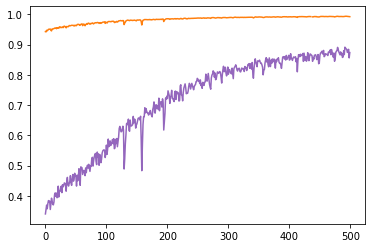

In [39]:
    plt.plot(epochs, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(epochs, training_ious, 'tab:purple', label='training iou')

In [6]:
model = UNet().to(device)

In [7]:
from torchsummary import summary

In [8]:
summary(model,(1,1536,512))

/home/yylab/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


RuntimeError: Given groups=1, weight of size [1, 256, 1, 1], expected input[2, 1024, 64, 64] to have 256 channels, but got 1024 channels instead

In [22]:
import matplotlib.pyplot as plt

In [56]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
test_path=root_dir+"txt/test.txt"
with open(test_path, "r") as test:
    lines_test =test.readlines()
    list_test=[i[:-1] for i in lines_test]

In [79]:
#mod="Final/checkpoint/480_0.7510523200035095.pth"
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_test[7]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

In [80]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]

S1_1_NORM = arr_x[1]
DEM_data=tifffile.imread(dem)
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0


In [81]:
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0

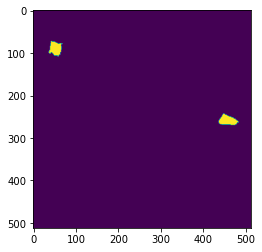

In [82]:
plt.imshow(Label_data[0])


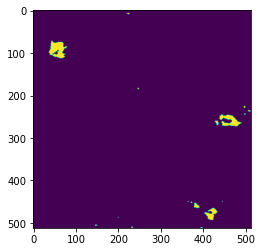

In [83]:
NET=UNet()
checkpoint = torch.load(path+mod)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
plt.imshow(a[0])

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet().to(device)

In [8]:
from torchsummary import summary
summary(model,(1,1536,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             584
       BatchNorm2d-5          [-1, 8, 512, 512]              16
              ReLU-6          [-1, 8, 512, 512]               0
            Conv2d-7         [-1, 16, 512, 512]           1,168
       BatchNorm2d-8         [-1, 16, 512, 512]              32
              ReLU-9         [-1, 16, 512, 512]               0
           Conv2d-10         [-1, 16, 512, 512]           2,320
      BatchNorm2d-11         [-1, 16, 512, 512]              32
             ReLU-12         [-1, 16, 512, 512]               0
           Conv2d-13          [-1, 8, 512, 512]              80
      BatchNorm2d-14          [-1, 8, 5

/home/yylab/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
